In [1]:
import os
import sys

sys.path.insert(0, "/trinity/home/asma.benachour/BrainBERT")
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
import models
import matplotlib.pyplot as plt
import numpy as np
import torch
from fpdf import FPDF
import random
from datetime import datetime
import csv
from omegaconf import OmegaConf
import pyedflib
from scipy import signal, stats

import pandas as pd

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import seaborn as sns

## Полезные функции

In [2]:
# === Функции ===
def edf_extractor(file_name):
    f = pyedflib.EdfReader(file_name)
    n = f.signals_in_file
    signal_labels = f.getSignalLabels()
    sigbufs = np.zeros((n, f.getNSamples()[0]))
    for i in np.arange(n):
        sigbufs[i, :] = f.readSignal(i)
    return sigbufs, signal_labels


def build_model(cfg):
    ckpt_path = cfg.upstream_ckpt
    init_state = init_state = torch.load(ckpt_path, weights_only=False)
    upstream_cfg = init_state["model_cfg"]
    upstream = models.build_model(upstream_cfg)
    return upstream


def load_model_weights(model, states, multi_gpu):
    if multi_gpu:
        model.module.load_weights(states)
    else:
        model.load_weights(states)


def initialize_model(ckpt_path: str):
    """
    Инициализация модели с заданным путем к контрольной точке (checkpoint).

    Args:
        ckpt_path (str): Путь к файлу контрольной точки.

    Returns:
        model: Инициализированная модель.
    """

    # Создание конфигурации и загрузка модели
    cfg = OmegaConf.create({"upstream_ckpt": ckpt_path})
    model = build_model(cfg)
    model.to("cuda")

    # Загрузка весов модели
    init_state = torch.load(ckpt_path, weights_only=False)
    load_model_weights(model, init_state["model"], False)

    return model


def create_save_dir(base_path: str, folder_name: str) -> str:
    """Создаёт директорию с именем, основанным на названии эксперимента,текущей дате и времени."""
    timestamp = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
    save_dir = os.path.join(base_path, f"{folder_name} on {timestamp}")
    os.makedirs(save_dir, exist_ok=True)
    return save_dir


def read_intervals_from_csv(file_path: str):
    """Читает интервалы из CSV-файла."""
    intervals = []
    activities = []
    with open(file_path, mode="r", encoding="utf-8") as csv_file:
        csv_reader = csv.reader(csv_file)
        for row in csv_reader:
            activities.append(row[0])
            intervals.append((float(row[1]), float(row[2])))
    return activities, intervals


def extract_intervals(original_file_path):
    """
    Преобразует оригинальный TSV файл в переменные для дальнейшей работы: activities, intervals и activity_type.

    Args:
        original_file_path (str): Путь к оригинальному TSV файлу.

    Returns:
        tuple: Три списка - activities, intervals и activity_type.
    """
    import pandas as pd

    # Чтение оригинального TSV файла
    df = pd.read_csv(original_file_path, sep="\t")

    # Извлечение необходимых столбцов
    required_columns = [
        "onset",
        "duration",
        "item_name",
        "trial_type",
        "test",
        "answer",
    ]
    if not all(col in df.columns for col in required_columns):
        raise ValueError(
            f"Оригинальный файл должен содержать столбцы: {required_columns}"
        )

    # Формирование интервалов, где конец интервала это onset следующего элемента
    onset_list = df["onset"].tolist() + [0]  # Добавляем 0 в конец
    intervals = [(onset_list[i], onset_list[i + 1]) for i in range(len(onset_list) - 1)]

    # Формирование activity_type
    activity_type = df["trial_type"].tolist()

    # Формирование activities с условием для PROB
    activities = [
        f"{test} = {answer}" if trial_type == "PROB" else item_name
        for test, answer, trial_type, item_name in zip(
            df["test"], df["answer"], df["trial_type"], df["item_name"]
        )
    ]

    return activities, intervals, activity_type


def get_model_outputs(stfts, model):
    # Форматирование тензоров и инференс модели
    inputs = torch.FloatTensor(np.stack(stfts)).transpose(1, 2).to("cuda")
    mask = torch.zeros((inputs.shape[:2])).bool().to("cuda")

    with torch.no_grad():
        out = model.forward(inputs, mask, intermediate_rep=True)
    return out


def universal_label_and_merge(
    group, search_col, mapping, default_label="OTHER", keep_labels=None
):
    """
    Универсальная функция для разметки и объединения интервалов в рамках одного трайала.

    Аргументы:
        group (pd.DataFrame): Датафрейм с событиями одного трайала.
                              Обязательно должен содержать столбцы "onset" и "duration".
        search_col (str): Имя столбца, по которому производится сопоставление (например, "trial_type").
        mapping (dict): Словарь вида {new_label (str): set(исходных меток)}.
        default_label (str): Ярлык для событий, не попавших ни в одну группу из mapping.

    Возвращает:
        pd.DataFrame с колонками ["label", "start", "end"].
    """
    # 1. Сортировка по времени
    group_sorted = (
        group.loc[:, ["onset", "duration", search_col]]
        .sort_values("onset")
        .reset_index(drop=True)
    )

    # 2. Корректировка столбца "duration"
    ind = group_sorted.columns.get_loc("duration")
    dur = group_sorted.iloc[-1, ind]
    group_sorted["duration"] = (
        group_sorted["onset"].diff(periods=-1).apply(lambda x: x * -1)
    )
    group_sorted.iloc[-1, ind] = dur

    # 3. Присваиваем новый ярлык каждому событию
    reverse_mapping = {
        orig_label: new_label
        for new_label, orig_labels in mapping.items()
        for orig_label in orig_labels
    }
    group_sorted["label"] = (
        group_sorted[search_col].map(reverse_mapping).fillna(default_label)
    )

    # 4. Вычисление конечных точек (start, end)
    group_sorted["end"] = group_sorted["onset"] + group_sorted["duration"]

    # 5. Группировка подряд идущих событий с одинаковым `label`
    group_sorted["group"] = (
        group_sorted["label"] != group_sorted["label"].shift()
    ).cumsum()

    merged_df = group_sorted.groupby("group", as_index=False).agg(
        label=("label", "first"), start=("onset", "first"), end=("end", "last")
    )

    # 6. Оставляем только интересующие метки (если указаны)
    if keep_labels is not None:
        merged_df = merged_df[merged_df["label"].isin(keep_labels)].reset_index(
            drop=True
        )

    return merged_df[["label", "start", "end"]]


# ## Класс STFTProcessor, разбивающий трайал сигнала активностям, добавляя левый паддинг с модификацией scipy.signal.stft, чтоб бины начинались с левой границы а не с середины
import numpy as np
import pandas as pd
from scipy import signal, stats
from typing import List, Tuple, Dict, Optional, Set


class STFTProcessor:
    """
    Класс для обработки сигналов с использованием STFT (Кратковременное преобразование Фурье).

    Функционал:
    - Преобразует интервалы из секунд в дискретные отсчёты.
    - Корректирует интервалы, устраняя артефакты округления.
    - Объединяет или дополняет короткие интервалы.
    - Выполняет STFT на обработанных интервалах с возможностью нормализации.

    Формат входных данных:
    - Массив сигнала с размерностями (число каналов, пиксели сигнала)
    - Пандас датафрейм интервалов
    """

    @staticmethod
    def baseline(data: np.ndarray) -> np.ndarray:
        """Вычисляет базовую линию, вычитая среднее значение по оси."""
        return data - np.mean(data, axis=-1, keepdims=True)

    def __init__(
        self,
        fs: int,
        window_size: int,
        overlap: int,
        normalizing: Optional[str] = "zscore",
        debug: bool = False,
        clip_fs: int = 40,
    ):
        """
        Инициализация класса STFTProcessor.

        :param fs: Частота дискретизации (Гц)
        :param window_size: Размер окна для STFT
        :param overlap: Количество перекрывающихся отсчётов
        :param normalizing: Способ нормализации ('zscore', 'baselined', 'db' или None)
        :param debug: Флаг для вывода отладочной информации
        """
        self.fs = fs
        self.window_size = window_size
        self.overlap = overlap
        self.normalizing = normalizing
        self.debug = debug
        self.effective_length = window_size - overlap
        self.left_padding = window_size - self.effective_length
        self.threshold = self.effective_length // 2
        self.clip_fs = clip_fs
        self.helpers = {
            "partial_intervals": self.trial_helper_partial_intervals,
            "full": self.trial_helper_full,
            "WORD": self.trial_helper_WORD,
        }
        self.kwargs_checker = {"WORD": {"orig_df", "activ_col", "value_col", "ref_activ", "interest_activ", "time_col"}}

    def _convert_intervals_to_samples(
        self, intervals_df: pd.DataFrame
    ) -> List[Dict[str, int]]:
        """
        Преобразует интервалы из секунд в отсчёты.

        :param intervals_df: DataFrame с колонками ["label", "start", "end"] в секундах
        :return: Список интервалов в отсчётах
        """
        intervals_df = intervals_df.copy()
        # Преобразование секунд в отсчёты
        intervals_df["start"] = (intervals_df["start"] * self.fs).round().astype(int)
        intervals_df["end"] = (intervals_df["end"] * self.fs).round().astype(
            int
        ) - 1  # Вычитание 1 для соответствия индексам

        intervals_list = intervals_df.to_dict(orient="records")
        return intervals_list

    def _merge_or_extend_intervals(
        self, intervals_samples: List[Dict[str, int]]
    ) -> List[Dict[str, int]]:
        """
        Объединяет или дополняет короткие интервалы, чтобы избежать пропусков.

        :param intervals_samples: Список интервалов в отсчётах
        :return: Обновленный список интервалов
        """
        i = 0
        processed_intervals = []
        while i < len(intervals_samples):
            current = intervals_samples[i]
            current_length = current["end"] - current["start"]
            modulo = current_length % self.effective_length
            division = current_length // self.effective_length
            needed = self.effective_length - modulo
            
            if i + 1 < len(intervals_samples):
                # Вычисляем available, считая, что интервалы заданы как закрытые [start, end]
                next_interval = intervals_samples[i + 1]
                available = next_interval["end"] - next_interval["start"] + 1
                # Если остаток превышает порог, пытаемся расширить или слить с следующим интервалом
                if modulo > self.threshold:
                    if available > needed:
                        next_interval["start"] += needed
                        current["end"] += needed
                        processed_intervals.append(current)
                        
                    else:
                        combined_end = intervals_samples.pop(i + 1)["end"]
                        current["end"] = combined_end
                        # После pop не увеличиваем i, так как следующий элемент смещается в текущую позицию.
                        continue

                # Если интервал достаточно длинный (division > 0), то проводим корректировку
                elif division > 0:
                    if modulo > 0:
                        next_interval["start"] -= modulo
                        current["end"] = next_interval["start"] - 1
                        processed_intervals.append(current)
                    elif modulo == 0:
                        processed_intervals.append(current)
                elif division == 0:
                    # Если интервал слишком короткий (division == 0)
                    if modulo >= 0:
                        combined_end = intervals_samples.pop(i)["start"]
                        intervals_samples[i]["start"] = combined_end
                        continue
                    # elif modulo == 0:
                    #     if self.debug:
                    #         print(f"[Interval {i}] DISCARDED: No valid length (division == 0, modulo == 0).")
                    #     intervals_samples.pop(i)
                    #     continue
            else:
                # Последний интервал: если он не соответствует условиям, пытаемся объединить с предыдущим
                if division > 0 and modulo == 0:
                    pass  # оставляем как есть
                else:
                    combined_end = intervals_samples.pop(i)["end"]
                    processed_intervals[i - 1]["end"] = combined_end
            i += 1
        return processed_intervals

    def trial_helper_partial_intervals(self, trial_signal: np.ndarray, intervals_samples: pd.DataFrame, **kwargs)-> Tuple[str, np.ndarray, np.ndarray, np.ndarray, float]:
        """
        Обрабатывает трайал, вычисляя STFT для заданных интервалов,
        и возвращает единую структуру с матрицей STFT и соответствующими метками.

        Возвращает словарь с ключами:
        - 't': 1D numpy массив временных меток для всех бинов
        - 'f': 1D numpy массив частотной сетки
        - 'Zxx': 2D numpy массив STFT-коэффициентов (shape = (n_f, n_time_bins))
        - 'labels': 1D numpy массив меток активности для каждого временного бина
        """
        t_all = []
        labels_all = []
        Zxx_list = []
        f_global = None
        intervals_samples = self._merge_or_extend_intervals(intervals_samples)

        # Обработка каждого интервала
        for idx, interval in enumerate(intervals_samples):
            segment = trial_signal[:, interval["start"] : interval["end"]]
            t_offset = interval["start"] / self.fs
            Zxx, f, t, last_t = self.process_interval(segment, t_offset)
            if f_global is None:  # частотная сетка должна быть одинаковой во всех интервалах
                f_global = f
            t_all.append(t)
            labels_all.extend([interval["label"]] * len(t))
            Zxx_list.append(Zxx)  # Zxx имеет форму (n_channels, n_f, n_t_interval)

        # Объединяем данные по времени
        t_all = np.concatenate(t_all)  # shape = (n_total_time_bins,)
        Zxx_all = np.concatenate(
            Zxx_list, axis=2
        )  # shape = (n_channels, n_f, n_total_time_bins)
        labels_all = np.array(labels_all)
        return {"t": t_all, "f": f_global, "Zxx": Zxx_all, "labels": labels_all}

    def trial_helper_full(self, trial_signal: np.ndarray, intervals_samples: pd.DataFrame, **kwargs)-> Tuple[str, np.ndarray, np.ndarray, np.ndarray, float]:
        """
        Обрабатывает трайал, вычисляя STFT для заданных интервалов,
        и возвращает единую структуру с матрицей STFT и соответствующими метками.
        На случай, если хочется честно получить STFT для объединённого сегмента

        Возвращает словарь с ключами:
        - 't': 1D numpy массив временных меток для всех бинов
        - 'f': 1D numpy массив частотной сетки
        - 'Zxx': 2D numpy массив STFT-коэффициентов (shape = (n_f, n_time_bins))
        - 'labels': 1D numpy массив меток активности для каждого временного бина
        """
        trial_segment = trial_signal[
            :, intervals_samples[0]["start"] : intervals_samples[-1]["end"]
        ]
        t_offset = intervals_samples[0]["start"] / self.fs
        Zxx_pure, f_pure, t_pure, _ = self.process_interval(trial_segment, t_offset)
        return {"t": t_pure, "f": f_pure, "Zxx": Zxx_pure}

    def trial_helper_WORD(self, trial_signal: np.ndarray, intervals_samples: pd.DataFrame, **kwargs)-> Tuple[str, np.ndarray, np.ndarray, np.ndarray, float]:
        """
        Обрабатывает трайал:
        1. Вычисляет STFT для сегмента сигнала, заданного interval_samples.
        2. Привязывает временные бины к реальному времени.
        3. Из orig_df отбирает события с активностью, равной interest_activ.
        4. По onsets этих событий строит интервалы с помощью:
                starts = [-∞] + interest_onsets[1:]
                ends   = interest_onsets[1:] + [+∞]
        5. Для каждого временного бина определяет, в какой интервал он попадает, через векторизованную булеву маску.
        6. По найденным индексам выбирает слово из value_col.
        7. Определяет вердикт для каждого слова:
                если слово содержится в передаваемом множестве референсов → "ref",
                иначе → "non-ref".
        8. Затем формирует новую матрицу из двух колонок: слово и вердикт.
        9. Результаты (временные метки, частотную сетку, матрицу STFT и итоговую матрицу из [слово, итоговый вердикт])
            возвращает в виде словаря.

        kwargs должны содержать:
        - orig_df: pd.DataFrame с оригинальными событиями
        - time_col: название колонки с временем (например, "onset")
        - activ_col: название колонки с активностями (например, "trial_type")
        - value_col: название колонки со словами (например, "item_name")
        - ref_activ: множество (или список) референсных строк (например, ["REC_WORD"])
        - interest_activ: строка, обозначающая интересующую активность (например, ["WORD"])

        Возвращает словарь с ключами:
        - 't': 1D numpy массив временных меток для всех бинов с привязкой к реальному времени эксперимента (как в ориг. датасете)
        - 'f': 1D numpy массив частотной сетки
        - 'Zxx': 2D numpy массив STFT-коэффициентов (shape = (n_f, n_time_bins))
        - 'labels': 1D numpy массив меток активности для каждого временного бина
        """
        required_keys = self.kwargs_checker["WORD"]
        if not required_keys.issubset(set(kwargs.keys())):
            missing = required_keys.difference(set(kwargs.keys()))
            raise Exception(f"Missing required kwargs: {missing}")

        orig_df = kwargs["orig_df"]
        time_col = kwargs["time_col"]
        activ_col = kwargs["activ_col"]
        value_col = kwargs["value_col"]
        ref_activ = kwargs["ref_activ"]
        interest_activ = kwargs["interest_activ"]
        
        trial_segment = trial_signal[
            :, intervals_samples[0]["start"] : intervals_samples[-1]["end"]
        ]
        t_offset = intervals_samples[0]["start"] / self.fs

        Zxx, f, t, _ = self.process_interval(trial_segment, t_offset)

        # Фильтруем события для интересующей активности
        interest_df = orig_df[orig_df[activ_col].isin(interest_activ)].reset_index(drop=True)
        reference_df = orig_df[orig_df[activ_col].isin(ref_activ)].reset_index(drop=True)
        if interest_df.empty:
            labels = np.full(t.shape, "None,none", dtype=object)
            return {"t": t, "f": f, "Zxx": Zxx, "labels": labels}

        # Извлекаем массив onsets для интересующих событий
        interest_onsets = interest_df[time_col].to_numpy()

        # --- Формирование интервалов по onsets ---
        # Начала: для первого события – -∞, для остальных – предыдущие onsets
        starts = np.concatenate(([-np.inf], interest_onsets[1:]))
        # Концы: для всех, кроме последнего – следующий onset, для последнего – +∞
        ends = np.concatenate((interest_onsets[1:], [np.inf]))

        # --- Определение принадлежности каждого временного бина к интервалу ---
        # Для каждого t[i] проверяем, принадлежит ли оно интервалу [starts[j], ends[j])
        interval_mask = (t[:, None] >= starts) & (t[:, None] < ends)
        # По каждой строке выбираем первый True – это и есть нужный индекс события
        matched_indices = interval_mask.argmax(axis=1)

        # --- Сопоставление слов ---
        # Из получаем массив слов из колонки value_col
        words_all = interest_df[value_col].to_numpy()
        reference_all = reference_df[value_col].to_numpy()
        # Для каждого временного бина выбираем слово по найденному индексу
        words = words_all[matched_indices]
        # --- Определение первоначального вердикта (по вхождению слова в множество ref_activ) ---
        verdict = np.where(np.isin(words, reference_all), "rec", "not-rec")

        # Итоговая матрица: первая колонка – исходное слово, вторая – итоговый вердикт (результат set-операции)
        final_stack = np.stack((words, verdict), axis=1)

        return {"t": t, "f": f, "Zxx": Zxx, "labels": final_stack}

    def process_trial(
        self, helpers: Set[str], trial_signal: np.ndarray, intervals: pd.DataFrame, **kwargs
    ) -> Dict[str, Dict[str, np.ndarray]]:
        """
        Обрабатывает трайал, по всем требуемым алгоритмам обработки

        Возвращает словарь:
        - 'helpers.keys()': Ключи
        - {"t": t, "f": f, "Zxx": Zxx, "labels": labels} : Значение. Каждый элемент словаря - объект numpy
        """
        result = {}
        # Преобразуем интервалы и объединяем их
        intervals_samples = self._convert_intervals_to_samples(intervals)

        if helpers.issubset(set(self.helpers.keys())):
            for key in helpers:
                result[key] = self.helpers[key](trial_signal, intervals_samples, **kwargs[key])
        else:
            raise Exception(f"Not expected helper name was found: {helpers.difference(set(self.helpers.keys()))}")
        return result

    def process_interval(
        self, segment: np.ndarray, t_offset: float = 0
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, float]:
        """
        Обрабатывает отдельный интервал сигнала.

        :param segment: Сегмент сигнала
        :param t_offset: Абсолютное смещение времени (в секундах)
        :return: (Zxx, f, t, последнее значение t)
        """
        # Генерирует данные STFT для одного указанного интервала записи.
        num_channels = segment.shape[0]

        full_stfts = []
        for channel in range(num_channels):
            # Подготовка сигнала: паддинг
            padded_signal = self._prepare_signal(segment[channel, :])

            # Вычисляем STFT
            f, t, Zxx = self._compute_stft(padded_signal)
            full_stfts.append(Zxx)

        # Применяем абсолютное смещение времени
        t += t_offset

        last_t = t[-1] if len(t) > 0 else t_offset

        return np.stack(full_stfts), f, t, last_t

    def _prepare_signal(self, segment: np.ndarray) -> np.ndarray:
        """
        Дополняет сигнал нулями для корректного разбиения окна.

        :param segment: Одномерный массив сигнала
        :return: Дополненный сигнал
        """
        padded_signal = np.pad(segment, (self.left_padding, 0), mode="constant")
        # padded_signal = segment
        return padded_signal

    def _compute_stft(self, x: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Вычисляет STFT и применяет нормализацию.

        :param x: Одномерный массив сигнала
        :return: Частотная ось, временная ось, STFT-коэффициенты
        """
        f, t, Zxx = signal.stft(
            x,
            self.fs,
            nperseg=self.window_size,
            noverlap=self.overlap,
            boundary=None,
            padded=True,
        )
        # f, t, Zxx = signal.stft(x, self.fs, nperseg=self.window_size, noverlap=self.overlap)

        # Преобразуем комплексные значения в абсолютные
        Zxx = Zxx[: self.clip_fs]
        f = f[: self.clip_fs]

        Zxx = np.abs(Zxx)

        clip = 5

        if self.normalizing == "zscore":
            # Zxx = Zxx[:, clip:-clip]
            Zxx = stats.zscore(Zxx, axis=-1)
            # t = t[clip:-clip]
        elif self.normalizing == "baselined":
            Zxx = Zxx[:, clip:-clip]
            Zxx = self.baseline(Zxx)
            t = t[clip:-clip]
        elif self.normalizing == "db":
            Zxx = Zxx[:, clip:-clip]
            Zxx = np.log2(Zxx)
            t = t[clip:-clip]
        else:
            print("Нормализация не применяется, сохраняем исходные значения.")


        return f, t, Zxx

## Main launchers

In [3]:
experimentation = input("Enter experimentation name without spaces:")
pdf_output_dir = "/trinity/home/asma.benachour/PDF/"
os.makedirs(pdf_output_dir, exist_ok=True)
# Создание директории для сохранения
save_dir = create_save_dir(pdf_output_dir, experimentation)

In [4]:
# === Параметры ===
# Пути к данным и моделям
ckpt_path = "/trinity/home/asma.benachour/BERT_init_weights/stft_large_pretrained.pth"
tsv_file_path = "/trinity/home/asma.benachour/Haydn Free recall/sub-R1001P/ses-0/ieeg/sub-R1001P_ses-0_task-FR1_events.tsv"

In [5]:
# Инициализация модели
model = initialize_model(ckpt_path)

subs = [
    "sub-R1001P",
    "sub-R1002P",
    "sub-R1003P",
    "sub-R1010J",
    "sub-R1015J",
    "sub-R1020J",
    "sub-R1026D",
    "sub-R1031M",
    "sub-R1032D",
    "sub-R1035M",
]

log_path = os.path.join(save_dir, f"log.txt")

/home/asma.benachour/miniconda3/envs/brainbert/lib/python3.10/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [70]:
# %reset

In [66]:
import zarr

preprocessed_files = "/trinity/home/asma.benachour/processed_files/"
sub = "sub-R1001P"
trial = 1
# Открываем весь train.zarr
z = zarr.open(f"{preprocessed_files}/{sub}/WORD.zarr", mode="r")

# Доступ к группе по trial
trial0 = z[f"trial_{trial}"]

# Открываем инфу о интервалах
intervals = pd.read_csv(f"{preprocessed_files}/{sub}/trial_intervals/{trial}.csv")

In [67]:
# Доступ к переменным внутри trial_0
Zxx = trial0["spectrogram"][:]  # загружаем как NumPy массив
freq = trial0["freq"][:]
time = trial0["time"][:]
labels = trial0["labels"][:]
embedding = trial0["embedding"][:]

### STFTProcessor init

In [6]:
SFTP = STFTProcessor(fs=500, window_size=400, overlap=350)

In [7]:
path_to = "/trinity/home/asma.benachour/Haydn Free recall/sub-R1001P/ses-0/ieeg/"
left_suff = "sub-R1001P_ses-0_task-FR1_acq-"
right_suff = "_ieeg.edf"
signal_types = ["monopolar", "bipolar"]
file_name = {}
recording = {}
signal_labels = {}
for s_type in signal_types:
    file_name[s_type] = f"{path_to}{left_suff}{s_type}{right_suff}"
    recording[s_type], signal_labels[s_type] = edf_extractor(file_name[s_type])
SamplingFrequency = 500
framecap = 50000

In [8]:
df = pd.read_csv(tsv_file_path, sep="\t")
df_trials = df[df["list"] > 0].copy()
df_trials.sort_values("onset", inplace=True)
mapping = {
    "COUNTDOWN": {"COUNTDOWN_START", "TRIAL", "COUNTDOWN_STOP", "COUNTDOWN_END"},
    "WORD": {"WORD"},
    "PROB": {"PROB"},
    "REC_WORD": {"REC_WORD"},
}

In [9]:
results = []
for trial_id, group in df_trials.groupby("list"):
    intervals = universal_label_and_merge(
        group, search_col="trial_type", mapping=mapping, default_label="OTHER"
    )
    results.append(intervals)

In [10]:
results[0][results[0]['label'] == "WORD"]

,label,start,end
2,WORD,213.233,242.522


In [47]:
df_iterator = df_trials.groupby("list").get_group,
settings = {
    "orig_df": None,
    "activ_col": "trial_type", 
    "value_col": "item_name", 
    "ref_activ": ["REC_WORD"], 
    "interest_activ": ["WORD"], 
    "time_col": "onset"
}

In [18]:
signal_types = ["monopolar", "bipolar"]
chosen_rec = "bipolar"

In [44]:
# trials_info = []
# channel_signal = recording[chosen_rec]
# itr = results[1]
# settings["orig_df"] = settings["orig_df"](2)
# sftp_trial = SFTP.process_trial({"WORD"}, channel_signal, itr[itr['label'] == "WORD"], WORD = settings)
# for t in list(sftp_trial.keys()):
#     with torch.no_grad():
#         sftp_trial[t]["BrainBert"] = get_model_outputs(sftp_trial[t]["Zxx"], model)
#         torch.cuda.empty_cache()
# sftp_trial["WORD"]["labels"]

In [49]:
trials_info = []
# channel_signal = recording[chosen_rec][channel]
channel_signal = recording[chosen_rec]
for i, itr in enumerate(results):
    settings["orig_df"] = df_iterator(i+1)
    sftp_trial = SFTP.process_trial({"WORD"}, channel_signal, itr[itr['label'] == "WORD"], WORD = settings)
    for t in list(sftp_trial.keys()):
        with torch.no_grad():
            sftp_trial[t]["BrainBert"] = get_model_outputs(sftp_trial[t]["Zxx"], model)
            torch.cuda.empty_cache()
    trials_info.append(sftp_trial)

In [56]:
np.unique(trials_info[0]["WORD"]["labels"][:, 1])

array(['not-rec'], dtype=object)

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
import time
from sklearn.gaussian_process.kernels import (
    RBF,
    Matern,
    RationalQuadratic,
    DotProduct,
    WhiteKernel,
)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

In [8]:
# Создание KFold с перемешиванием
kf = KFold(n_splits=5, shuffle=True)

# Модели
classification_models = {
    # "Logistic regression": LogisticRegression(C=100, penalty="l1", solver="liblinear", max_iter=5000, class_weight="balanced"), #C=100, penalty="l1"
    # "KNN with best n_neighbors=5": KNeighborsClassifier(n_neighbors=5, weights="distance", metric="manhattan"), #n_neighbors=5, weights="distance"
    # "SVC with kernel rbf, C=100": SVC(kernel="rbf", C=100, gamma="auto", probability=True),
    # "RandomForest with 300 estimators": RandomForestClassifier(n_estimators=300, max_depth=15, random_state=42, class_weight="balanced"), # n_estimators=300, max_depth=15
    # "Decision Tree with max_depth=15": DecisionTreeClassifier(max_depth=15, min_samples_leaf=5, criterion="entropy", random_state=42),
    # "AdaBoost with n_estimators=200": AdaBoostClassifier(n_estimators=200, learning_rate=0.2, estimator=DecisionTreeClassifier(max_depth=1), random_state=42)
}

# Пример словаря: для COUNTDOWN объединяем "COUNTDOWN_START" и "TRIAL", для WORD – "WORD", для PROB – "PROB", для REC_WORD – "REC_WORD"
mapping = {
    "COUNTDOWN": {"COUNTDOWN_START", "TRIAL", "COUNTDOWN_STOP", "COUNTDOWN_END"},
    "WORD": {"WORD"},
    "MATH": {"PROB"},
    "REC_WORD": {"REC_WORD"},
}

In [11]:
def plot_time_series(wav, smpl_rate):
    plt.figure(figsize=(10, 3))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel("Voltage (\u03bcV)", fontsize=25)
    plt.xticks(
        np.arange(0, len(wav) + 1, smpl_rate),
        [x / smpl_rate for x in np.arange(0, len(wav) + 1, smpl_rate)],
    )
    plt.xlabel("Time (s)", fontsize=25)
    plt.plot(wav)

In [ ]:
# Проход по моделям
print("entering cross validation")
for name, mod in classification_models.items():
    y_true, y_pred = list(), list()
    start = time.time()
    y_test_arr = []
    y_hat_arr = []
    for train_ix, test_ix in kf.split(trials_info):
        try:
            # Разделение данных
            # эмбеддинги из спектрограммы 'train' находятся в первом батче
            X_train = np.concatenate(
                [trials_info[i]["BrainBert"][1].cpu().numpy() for i in train_ix], axis=0
            )
            X_test = np.concatenate(
                [trials_info[i]["BrainBert"][1].cpu().numpy() for i in test_ix], axis=0
            )
            # Используем только лейблы из трейна
            y_train = np.concatenate(
                [trials_info[i]["train"]["labels"] for i in train_ix], axis=0
            )
            y_test = np.concatenate(
                [trials_info[i]["train"]["labels"] for i in test_ix], axis=0
            )

            pca = PCA(n_components=2).fit(X_train)
            proj_train = pca.transform(X_train)
            proj_predict = pca.transform(X_test)

            # Обучение модели
            mod.fit(proj_train, y_train)

            # Предсказание
            y_hat = mod.predict(proj_predict)
            y_test_arr.append(y_test.astype(int))
            y_hat_arr.append(y_hat.astype(int))
            # Запись
            y_true.extend(y_test.astype(int))
            y_pred.extend(y_hat.astype(int))

            end = time.time()
            length = end - start

            # Вычисление accuracy
            acc = accuracy_score(y_true, y_pred)
            with open(log_path, "a") as f:
                f.write(
                    f"Patient: {sub}. Accuracy score ({name}): {acc:.3f}; It took {length:.2f} seconds!\n"
                )
        except Exception as e:
            with open(log_path, "a") as f:
                f.write(
                    f"""
==============================================
something went wrong in cross validation at patient {sub}
train_ix: {train_ix}
test_ix: {test_ix}
{e}
==============================================
"""
                )
    sub_state_dickt[sub]["y_test"] = y_test_arr
    sub_state_dickt[sub]["y_hat"] = y_hat_arr

In [13]:
sub_state_dickt["sub-R1001P"].keys()

dict_keys(['results', 'trials_info', 'labels', 'y_test', 'y_hat'])

In [16]:
sub_state_dickt["sub-R1001P"]["labels"]

array(['COUNTDOWN', 'MATH', 'OTHER', 'REC_WORD', 'WORD'], dtype='<U9')

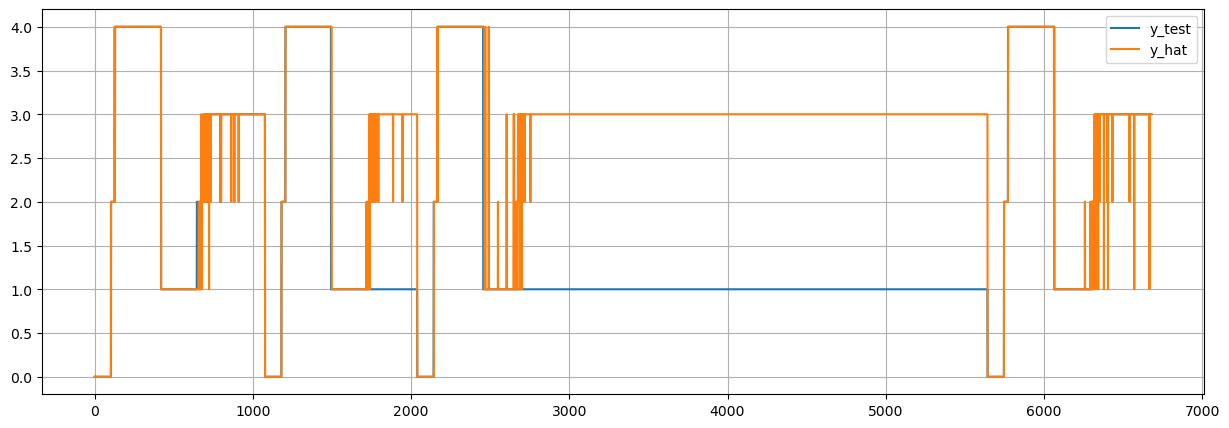

In [27]:
No_of_trial = 4

fig = plt.figure(figsize=(15, 5))
plt.plot(sub_state_dickt["sub-R1001P"]["y_test"][No_of_trial])
plt.plot(sub_state_dickt["sub-R1001P"]["y_hat"][No_of_trial])
plt.grid(True)
plt.legend(["y_test", "y_hat"])